# Prelude

Because of the IS-Academia website's *interesting* design choices, sacrificing a few goats to the deity of your choice may be required to fully understand this code.

In the immortal words of Dante Alighieri: **Lasciate ogni speranza, voi ch'entrate!**

# Fetching the data

First, let's import the libs we need.

In [131]:
# Usual stuff, as with previous homework
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

import requests # HTTP requests
from bs4 import BeautifulSoup # HTML parsing
import re # Regular expressions :(

And declare an useful type for students:

In [123]:
from collections import namedtuple

Student = namedtuple("Student", ["name", "gender"])

Then, let's get the index form, i.e. the base page we'll use to get all data:

In [90]:
# It's just an URL with a few weird symbols, how complex can it be?
index_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter"

# ...requesting that doesn't return anything, turns out we need URL parameters.
# Surely it's simple and self-descriptive?
index_params = {
    # ...oh well...
    "ww_i_reportmodel": "133685247" 
}

index_html = requests.get(index_url, params=index_params).text
index_page = BeautifulSoup(index_html, "lxml")

Then, fetch the page containing all of the "Informatique" (CS) links:

In [94]:
# Get the parameters for that page by fetching all of the "hidden" parameters, then adding our own to select CS.
info_index_params = dict([(i["name"], i["value"]) for i in index_page.findAll("input", attrs={"type": "hidden"})])

# Find the "HTML" option, get its value.
# Ideally we'd also find its name by looking for "HTML", but ISA doesn't use radiobuttons like normal people do,
# instead they have a button then some text right next to it, so looking for "html" will just find the text. :/
info_index_params["ww_i_reportModelXsl"] = index_page.find("input", attrs={"name": "ww_i_reportModelXsl"})["value"]

# Find the "Informatique" option, get its value
info_index_params["ww_x_UNITE_ACAD"] = index_page.find("option", text="Informatique")["value"]

info_index_html = requests.get(index_url, params=info_index_params).text
info_index_page = BeautifulSoup(info_index_html, "lxml")

Looking at the page in a browser, there are links.  
Have you ever heard of links? You define them with text, and an URL the user will go to if they click on the link.

...well, that's how normal people do links.  
IS-Academia does links that lead to nowhere, with JavaScript intercepting the click, creating an URL by manually scanning the user input on the page, setting a nested webpage's URL to that, and then reloading the page.

In [124]:
def find_semesters(name):
    """Find all semesters in Informatique matching the given regex."""
    semesters_by_id = []
    for link in info_index_page.findAll("a", attrs={"class": "ww_x_GPS"}):
        # Parse the link name, to find the year + semester
        link_name_match = re.search("Informatique, (\d+)-\d+, " + name, link.text)
        
        # Ignore weird stuff
        if link_name_match is None:
            continue
        
        # Find the link ID inside the onclick JavaScript.
        # ...
        # ...
        # ...why? just... why? why would anybody ever write a webpage like this?
        link_id_match = re.search(r"ww_x_GPS=(\d+)", link["onclick"])

        semesters_by_id.append((link_id_match.group(1), link_name_match.group(1)))
           
    # Now filter them to keep only 2007 and onwards.
    # Also remove those 2017 and later, since that hasn't happened yet so the data would be of dubious value.
    semesters_by_id = [v for v in semesters_by_id if 2007 <= int(v[1]) <= 2016]
    
    # Are you scared yet? Now it gets worse!
    students_by_semester = []
    for semester in semesters_by_id:
        # For some reason the URL is now .html instead of .filter
        semester_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html"
        
        # The parameters are the same as before, except now there's ww_x_GPS for the semester ID
        semester_params = info_index_params.copy()
        semester_params["ww_x_GPS"] = semester[0]
        
        semester_html = requests.get(semester_url, params=semester_params).text
        semester_page = BeautifulSoup(semester_html, "lxml")
        
        students = []
        # Iterate all rows, except the ones that have headers
        for row in semester_page.findAll("tr"):
            if row.contents[0].name != "th":
                # Just get the name!
                # It's the 2nd column. Can't be that hard.
                student_name = row.contents[1].text
                
                # ...oh wait. Instead of a normal space, it's a non-breaking space.
                # So let's replace that...
                student_name = student_name.replace("\xa0", " ")
                
                # Also, we need the gender
                student_gender = "M" if row.contents[0].text == "Monsieur" else "F"
                
                students.append(Student(name=student_name, gender=student_gender))
        
        # Aaand we're done. Finally.
        students_by_semester.append((semester[1], students))
        
    return students_by_semester

Now that we can extract students by semester, we can do fun stuff!  
And by "fun stuff", I mean "what the homework asks for".

# Time to get from Bachelor 1 to Bachelor 6

So let's first find all students that were in Bachelor 1 and Bachelor 6 at some point.  
Also find the Bachelor 5, since at EPFL if you fail BA-6 and need to do an additional semester, you're back in BA-5.

In [191]:
students_ba1 = find_semesters("Bachelor semestre 1")
students_ba5 = find_semesters("Bachelor semestre 5")
students_ba6 = find_semesters("Bachelor semestre 6")

Then, make a Pandas frame from students who were in both, and the years they were in them, to get durations.

Note that the ISA data does not contain outcomes, i.e. students who failed their BA-6 and abandoned will get counted as having done their Bachelor in 3 years.

In [193]:
ba_students = []
known_students = set()

for students_by_year in students_ba1:
    begin_year = students_by_year[0]
    for student in students_by_year[1]:
        if student in known_students:
            # Student redoing their 1st year, ignore
            continue
        known_students.add(student)
        
        end_year = [sby[0] for sby in students_ba6 if student in sby[1]]
        if len(end_year) != 0:
            # Get the "real" end year, i.e. the last one the student was in.
            end_year = end_year[-1]
            # +1 since it's a range, e.g. between 2006 and 2008 -> 3 years (2006, 2007, 2008)
            duration = int(end_year) - int(begin_year) + 1
            
            # Now see if there's a later year in BA-5, i.e. the student did their bachelor in an odd # of semesters
            ba5_end_year = [sby[0] for sby in students_ba5 if student in sby[1]]
            # We know the above list has >=1 elem since the student was in BA-6 at some point
            if ba5_end_year[-1] > end_year:
                duration += 0.5
            
            # We don't care about the name any more
            ba_students.append({
                    "gender": student.gender,
                    "duration": duration
                })

ba_students = pd.DataFrame(ba_students)

Compute fractions of students by duration and gender:

In [194]:
# Group the students
ba_groups = ba_students.groupby("duration")

# Helper method to get men/women from a frame
def of_gender(series, gender):
    return series[series["gender"] == gender]

# First, total sums: how many men and women?
ba_men = of_gender(ba_students, "M").size
ba_women = of_gender(ba_students, "F").size

# Then, fractions: what % of each gender took N years?
ba_frac_per_gender = []
for group in ba_groups:
    students = group[1]
    ba_frac_per_gender.append({
            "duration": group[0],
            "men": of_gender(students, "M").size / ba_men,
            "women": of_gender(students, "F").size / ba_women
        })

ba_frac_per_gender = pd.DataFrame(ba_frac_per_gender)
ba_frac_per_gender = ba_frac_per_gender.set_index(["duration"])

Then display and plot it, to get a good idea of what the data looks like:

,men,women
duration,,
3.0,0.552846,0.689655
3.5,0.094851,0.034483
4.0,0.184282,0.137931
4.5,0.062331,0.103448
5.0,0.059621,0.000000
5.5,0.027100,0.034483
6.0,0.016260,0.000000
7.0,0.002710,0.000000


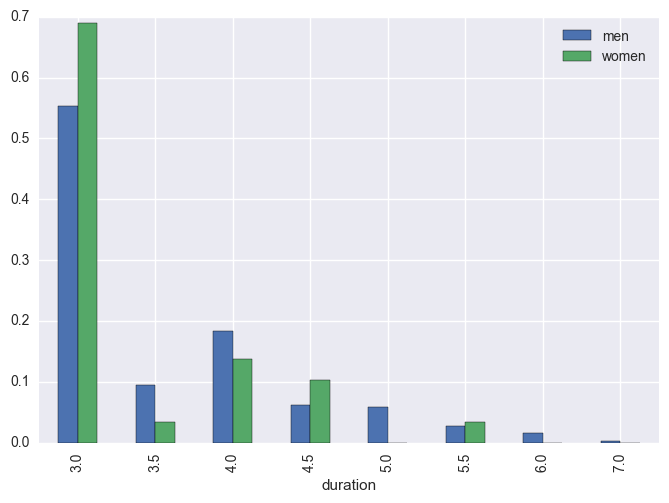

In [195]:
ba_frac_per_gender.plot.bar()
ba_frac_per_gender

Now compute the average:

In [196]:
def show_student_info(gender):
    duration = of_gender(ba_students, gender)["duration"]
    print(gender + ": mean = " + str(duration.mean()) + ", stdev = " + str(duration.std()))

show_student_info("M")
show_student_info("F")

M: mean = 3.5718157181571817, stdev = 0.7877231972673742
F: mean = 3.396551724137931, stdev = 0.6732027706741481


Men take slightly longer to do their Bachelor, with a larger standard deviation as well.

However, there are (unfortunately!) only few women in CS bachelor, so the numbers may not mean that much:

In [197]:
print("Men: " + str(ba_men) + ", women: " + str(ba_women))

Men: 738, women: 58


:(